# Import packages

In [53]:
import sqlite3

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
db_path = 'diabetes.db'
con = sqlite3.connect(db_path)
cur = con.cursor()

In [3]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('diabetes',)]


In [4]:
cur.execute('SELECT * FROM diabetes')
col_names = [description[0] for description in cur.description]

df = pd.DataFrame(cur.fetchall(), columns=col_names)
con.close()
df.head()

,Age,Gender,Polyuria,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Obesity,Class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


Bộ dữ liệu được thu thập bằng cách hỏi trực tiếp các bệnh nhân tiểu đường tại bệnh viện bệnh Tiểu đường Sylhet, Sylhet, Bangladesh đã được chấp thuận bởi bác sĩ.

* Age: Tuổi
* Gender: Giới tính
* Polyuria: Đa niệu (Tình trạng đi tiểu nhiều hơn 2 lít / ngày)
* Polydipsia: Khát dữ dội mặc dù uống nhiều nước
* sudden weight loss: Sút cân đột ngột
* weakness: Mệt mỏi
* Polyphagia: Thèm ăn
* Genital thrush: Tưa miệng
* visual blurring: Mắt mờ
* Itching: Ngứa
* Irritability: Cáu gắt
* delayed healing: Vết thương lâu lành
* partial paresis: Bị liệt một phần
* muscle stiffness: Cứng cơ
* Alopecia: Rụng tóc từng vùng
* Obesity: Béo phì

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   Sudden Weight Loss  520 non-null    object
 5   Weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital Thrush      520 non-null    object
 8   Visual Blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  Delayed Healing     520 non-null    object
 12  Partial Paresis     520 non-null    object
 13  Muscle Stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  Class               520 no

**Số lượng các class:**

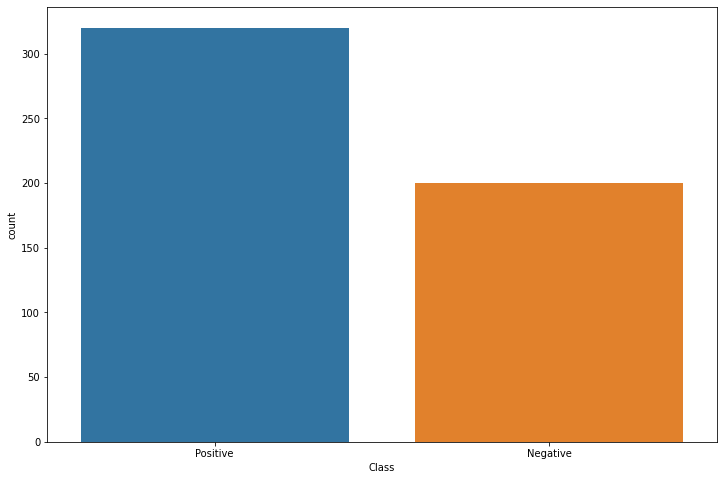

In [6]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Class')
plt.show()

In [7]:
print(df['Class'].value_counts() / df.shape[0] * 100)

Positive    61.538462
Negative    38.461538
Name: Class, dtype: float64


# Split Dataset

In [8]:
train, test = train_test_split(
    df, stratify=df['Class'],
    test_size=0.1,
    random_state=42
)

In [9]:
train.replace(['Yes', 'No'], [1, 0], inplace=True)
train.replace(['Male', 'Female'], [1, 0], inplace=True)
train.replace(['Positive', 'Negative'], [1, 0], inplace=True)

In [10]:
X = train.copy()
y = X.pop('Class')

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

In [12]:
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = test.shape[0]
n_df = df.shape[0]

print(f'Training-set: {n_train} ({n_train / n_df * 100:.2f} %)')
print(f'Valid-set: {n_valid} ({n_valid / n_df * 100:.2f} %)')
print(f'Test-set: {n_test} ({n_test / n_df * 100:.2f} %)')

Training-set: 374 (71.92 %)
Valid-set: 94 (18.08 %)
Test-set: 52 (10.00 %)


# EDA

In [13]:
train_df = pd.concat([X_train, y_train], axis=1)

In [14]:
train_df.head()

,Age,Gender,Polyuria,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Obesity,Class
165,40,0,1,1,1,1,0,0,1,0,0,1,1,1,0,0,1
219,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
245,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
388,43,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0
404,47,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0


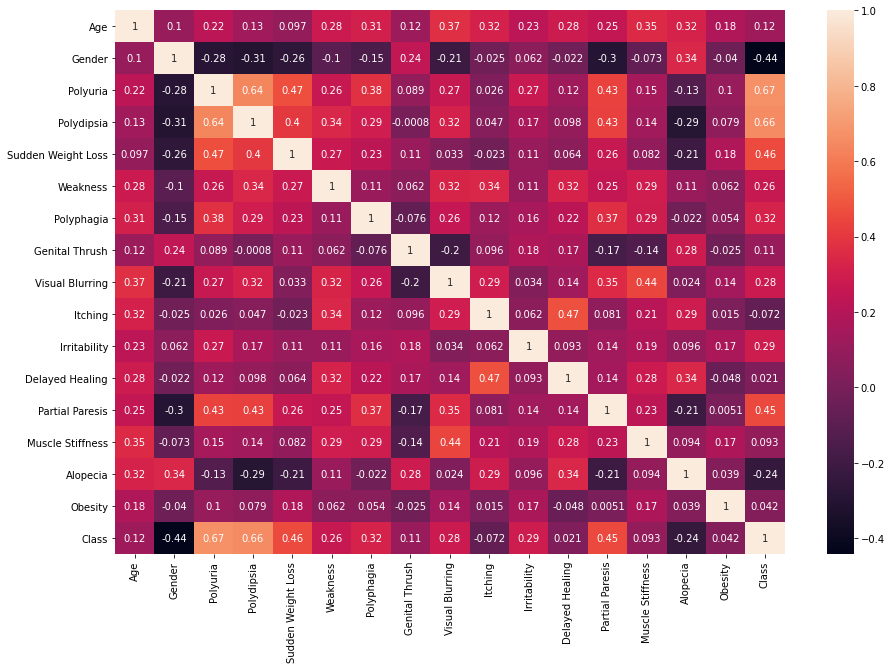

In [15]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_df.corr(), annot=True)
plt.show()

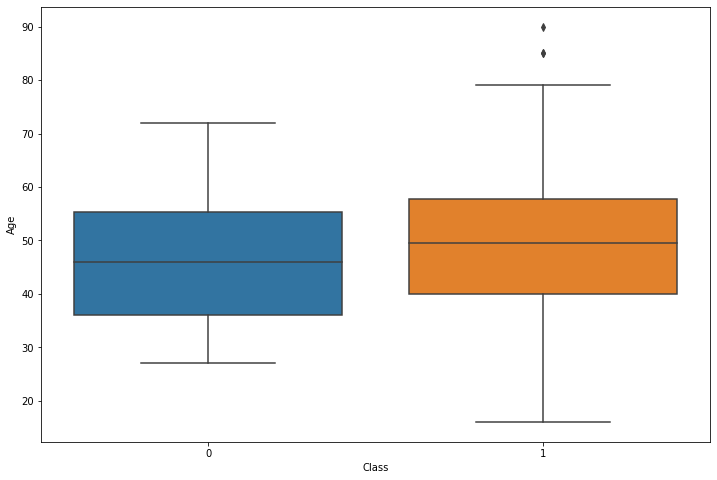

In [81]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df, y='Age', x='Class')
plt.show()

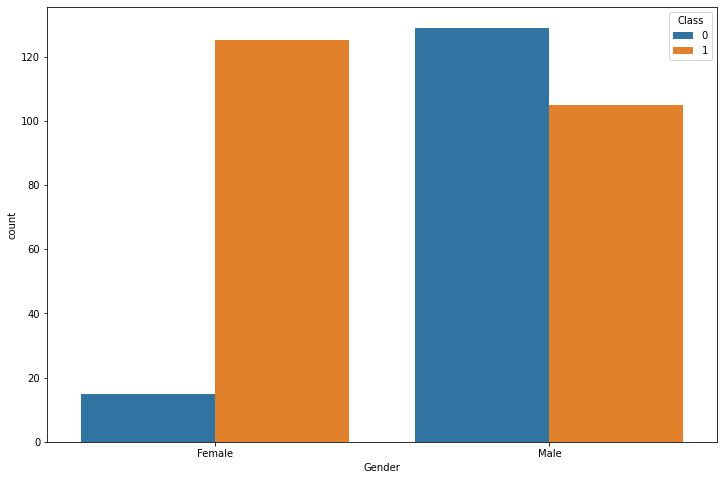

In [90]:
plt.figure(figsize=(12, 8))
sns.countplot(data=train_df, x='Gender', hue='Class')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

# Custom Functions

In [18]:
def plot_confusion_heatmap(y_pred, y):
    sns.heatmap(confusion_matrix(y_pred, y), annot=True, cmap='viridis')
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.3, 1.3], ['Negative', 'Positive'])
    plt.xlabel('Actual')
    plt.ylabel('Predict')
    plt.show()

In [19]:
def plot_roc(X, y, estimator):
    yhat = estimator.predict_proba(X)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y, yhat, pos_label=1)
    # plot the roc curve for the model
    plt.figure(figsize=(12, 8))
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the plot
    plt.legend(loc='lower right')
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold = %.2f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))
    plt.show()

In [20]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), title=None):
    f, ax = plt.subplots(figsize=(12, 8))
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='#ff9124')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='#2492ff')
    ax.plot(train_sizes, train_scores_mean, 'o-', color='#ff9124',
             label='Training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='#2492ff',
             label='Cross-validation score')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Training size (m)')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc='best')
    plt.show()

# Baseline Model

In [21]:
scaler = MinMaxScaler()
X_train['Age'] = scaler.fit_transform(np.array(X_train['Age']).reshape(-1, 1))

In [22]:
baseline_model = LogisticRegression(solver='liblinear')
baseline_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [23]:
X_valid.replace(['Yes', 'No'], [1, 0], inplace=True)
X_valid.replace(['Male', 'Female'], [1, 0], inplace=True)

X_valid['Age'] = scaler.transform(np.array(X_valid['Age']).reshape(-1, 1))

In [24]:
y_train_pred = baseline_model.predict(X_train)
train_acc = accuracy_score(y_train_pred, y_train)
print(train_acc)

0.9491978609625669


In [25]:
y_pred = baseline_model.predict(X_valid)
pred_acc = accuracy_score(y_pred, y_valid)
print(pred_acc)

0.8936170212765957


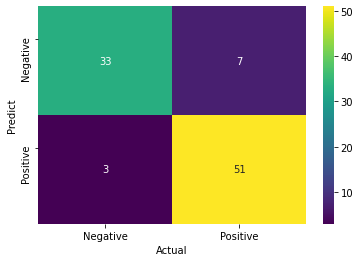

In [26]:
plot_confusion_heatmap(y_pred, y_valid)

In [27]:
print(classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87        40
           1       0.88      0.94      0.91        54

    accuracy                           0.89        94
   macro avg       0.90      0.88      0.89        94
weighted avg       0.90      0.89      0.89        94



Best Threshold = 0.44, G-Mean = 0.915


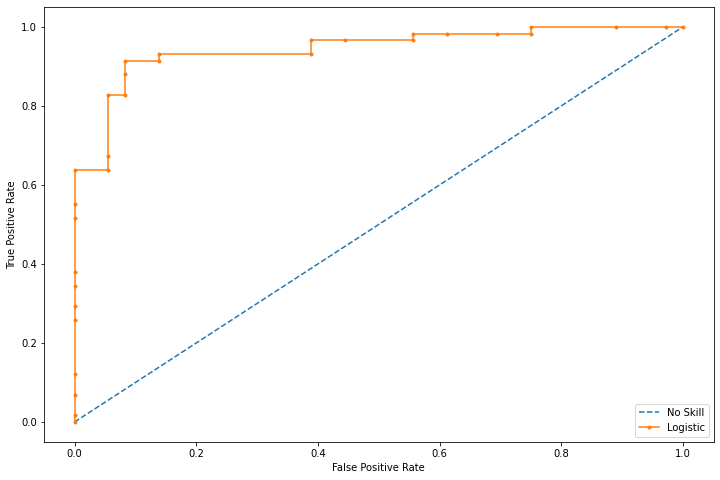

In [29]:
plot_roc(X_valid, y_valid, baseline_model)

In [30]:
print(f'Training Error: {100-train_acc*100:.2f} %')
print(f'Valid Error: {100-pred_acc*100:.2f} %')

Training Error: 5.08 %
Valid Error: 10.64 %


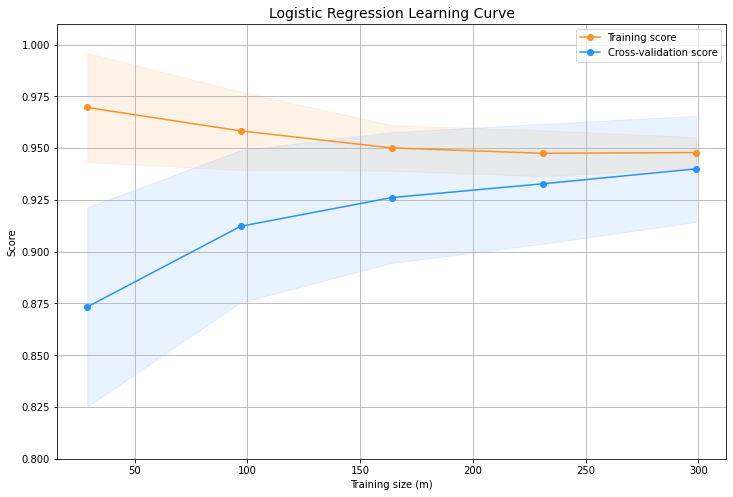

In [31]:
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)

plot_learning_curve(
    baseline_model, X_train, y_train,
    (0.8, 1.01), cv=cv, n_jobs=4,
    title='Logistic Regression Learning Curve'
)

In [32]:
importance = baseline_model.coef_[0]

for i, v in zip(importance, X_train.columns):
    print(f'Feature: {v}, Score: {i:.5f}')

Feature: Age, Score: -0.54576
Feature: Gender, Score: -2.33587
Feature: Polyuria, Score: 2.03540
Feature: Polydipsia, Score: 2.69797
Feature: Sudden Weight Loss, Score: 0.96736
Feature: Weakness, Score: 0.64565
Feature: Polyphagia, Score: 0.57283
Feature: Genital Thrush, Score: 1.18000
Feature: Visual Blurring, Score: 0.87596
Feature: Itching, Score: -1.51787
Feature: Irritability, Score: 1.47197
Feature: Delayed Healing, Score: -0.48911
Feature: Partial Paresis, Score: 1.06681
Feature: Muscle Stiffness, Score: -0.49528
Feature: Alopecia, Score: -0.21858
Feature: Obesity, Score: -0.31012


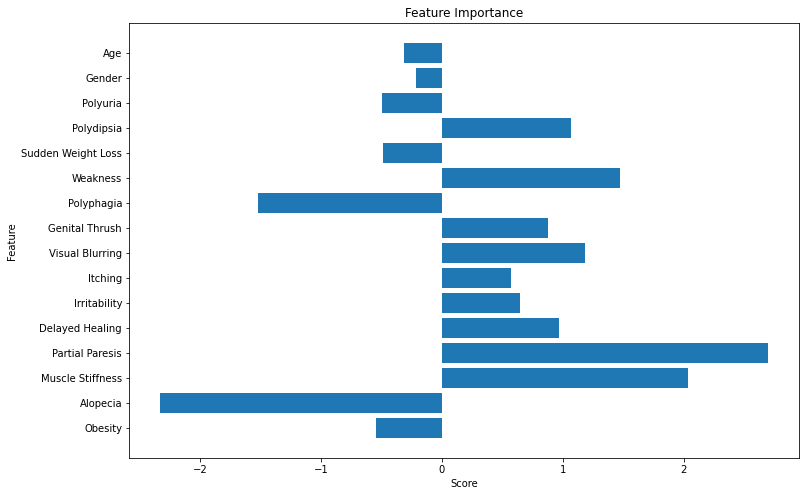

In [33]:
plt.figure(figsize=(12, 8))
plt.barh(X_train.columns[::-1], importance)
plt.title('Feature Importance')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

# XGBoost

In [34]:
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=[0, 1], random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=[0, 1], validate_parameters=1, verbosity=None)

In [35]:
y_pred = xgb.predict(X_valid)
print(accuracy_score(y_pred, y_valid))

0.9893617021276596


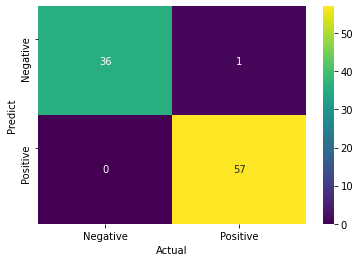

In [36]:
plot_confusion_heatmap(y_pred, y_valid)

In [37]:
print(classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.98      1.00      0.99        57

    accuracy                           0.99        94
   macro avg       0.99      0.99      0.99        94
weighted avg       0.99      0.99      0.99        94



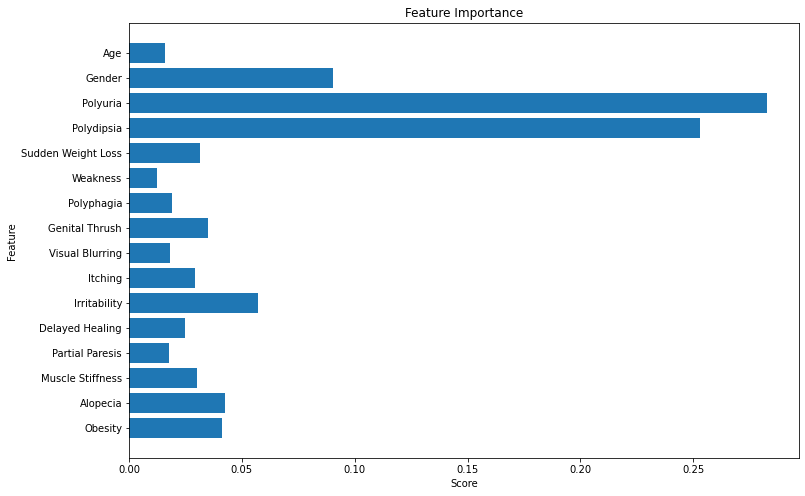

In [50]:
plt.figure(figsize=(12, 8))
plt.barh(X_valid.columns[::-1], xgb.feature_importances_[::-1])
plt.title('Feature Importance')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

In [39]:
# show mismatch predict

idx = []
count = 0
for i, j in zip(y_pred, y_valid):
    if i != j:
        idx.append(count)
    count += 1
    
ana = X_valid.iloc[idx]
ana['Age'] = scaler.inverse_transform(ana['Age'].values.reshape(-1, 1))
ana['Actual'] = [y_valid[i] for i in idx]
ana['Predict'] = [y_pred[i] for i in idx]

ana

,Age,Gender,Polyuria,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Obesity,Actual,Predict
2,41.0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0


In [40]:
xgb.predict_proba(X_valid.iloc[idx])

array([[0.6386266 , 0.36137345]], dtype=float32)

In [41]:
y_pred = xgb.predict_proba(X_valid)
y_pred = [1 if i[0] < 0.64 else 0 for i in y_pred]

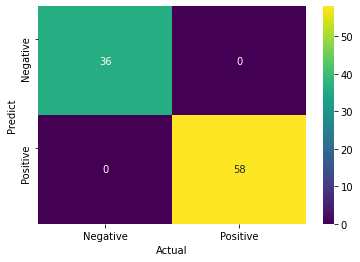

In [42]:
plot_confusion_heatmap(y_pred, y_valid)

Best Threshold = 0.36, G-Mean = 1.000


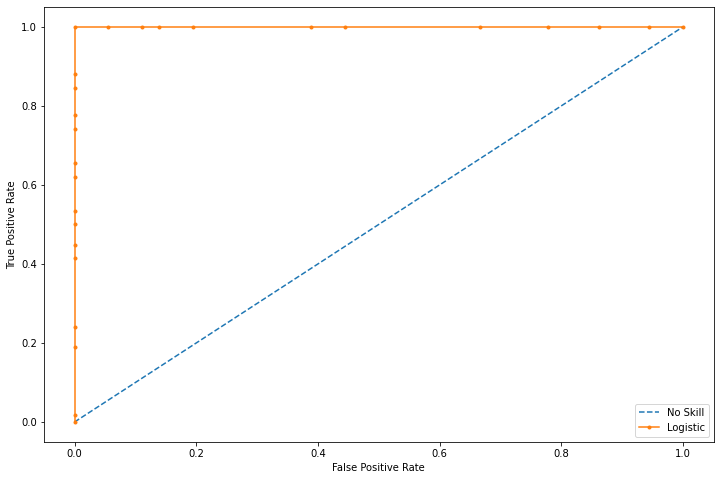

In [43]:
plot_roc(X_valid, y_valid, xgb)

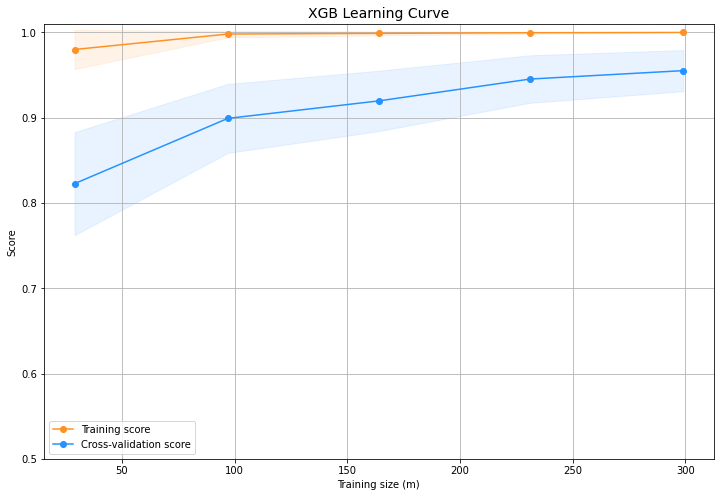

In [44]:
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)

plot_learning_curve(
    xgb, X_train, y_train,
    (0.5, 1.01), cv=cv,
    title='XGB Learning Curve'
)

# Test Final Model

In [45]:
test.replace(['Yes', 'No'], [1, 0], inplace=True)
test.replace(['Male', 'Female'], [1, 0], inplace=True)
test.replace(['Positive', 'Negative'], [1, 0], inplace=True)

In [46]:
X_test = test.copy()
y_test = X_test.pop('Class')

In [47]:
y_pred_test = xgb.predict_proba(X_test)
y_pred_test = [1 if i[0] < 0.64 else 0 for i in y_pred_test]

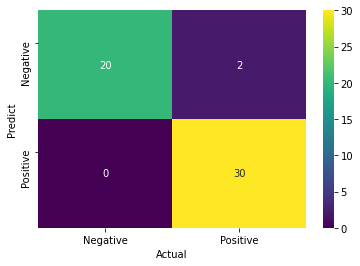

In [48]:
plot_confusion_heatmap(y_pred_test, y_test)

In [49]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.94      1.00      0.97        30

    accuracy                           0.96        52
   macro avg       0.97      0.95      0.96        52
weighted avg       0.96      0.96      0.96        52



# Save model and preprocessing

In [ ]:
# use package pickle

pickle.dump(xgb, open('model.sav', 'wb'))
pickle.dump(scaler, open('scaler.sav', 'wb'))